In [1]:
import os
os.chdir('..')

In [2]:
%load_ext dotenv
%dotenv -o .env

In [3]:
DATA_DIR = os.environ['DATA_DIR']
RESULTS_DIR = os.environ['RESULTS_DIR']

### Calibrate the model

In [4]:
import pickle
import datetime
import lightgbm as lgb
from ta.preprocess import get_data
from ta.training import get_feature_names, get_loss_fct_weights
from ta.calibration import GBMWrapped
from ta.calibration.calibration_curve import get_calibration_figure

import numpy as np
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import brier_score_loss, precision_score, recall_score, f1_score, auc, roc_curve, confusion_matrix

In [5]:
bst = lgb.Booster(model_file=os.path.join(RESULTS_DIR, 'model.txt'))

data, le, le_countries = get_data(
        data_dir=DATA_DIR, load_data=True, save_data=False, countries_overwrite=False, nrows=None, google_api_key=None
)

t_train = datetime.datetime(2017, 4, 29)
t_val = datetime.datetime(2017, 5, 1)
test_cond = data['ts'] > t_val

train_cond = data['ts'] < t_train
val_cond = data['ts'].between(t_train, t_val)
test_cond = data['ts'] > t_val

contiuous_columns, categorical_columns, target_col, data_info = get_feature_names(data)

weights_train = get_loss_fct_weights(data, train_cond, target_col)
weights_val = get_loss_fct_weights(data, val_cond, target_col)
weights_test = get_loss_fct_weights(data, test_cond, target_col)


In [6]:
# data.loc[train_cond].shape, data.loc[val_cond].shape, data.loc[test_cond].shape
data.head(2)

,ts,event_type,user_id,date_from,date_to,origin,destination,num_adults,num_children,lat_origin,...,d_origin,d_destination,d_od_pair,d_num_adults,d_num_children,dt_ts,d_origin_dist,d_destination_dist,attempt_n,n_od_pairs
0,2017-04-29 17:59:51,0,000069,2017-05-10,2017-05-26 00:00:00,93,9,2,3,50.08,...,0,0,0,0,0,-1.0,-1.0,-1.0,1,1
1,2017-04-28 19:14:23,0,00019d,2017-09-15,2017-10-13 00:00:00,190,232,4,0,48.85,...,0,0,0,0,0,-1.0,-1.0,-1.0,1,1


In [7]:
x_train = data.loc[train_cond, contiuous_columns + categorical_columns]
x_val = data.loc[val_cond, contiuous_columns + categorical_columns]
x_test = data.loc[test_cond, contiuous_columns + categorical_columns]

y_train = data.loc[train_cond, target_col]
y_val = data.loc[val_cond, target_col]
y_test = data.loc[test_cond, target_col]

y_pred_train = bst.predict(x_train)
y_pred_val = bst.predict(x_val)
y_pred_test = bst.predict(x_test)

In [8]:
gbm_wrapped = GBMWrapped(bst)
model_calibrated = CalibratedClassifierCV(gbm_wrapped, cv='prefit', method='isotonic')  # 'isotonic', 'sigmoid'
model_calibrated.fit(x_train, y_train, weights_train.values)


CalibratedClassifierCV(base_estimator=<ta.calibration.GBMWrapped object at 0x7ff1d0855d50>,
                       cv='prefit', method='isotonic')

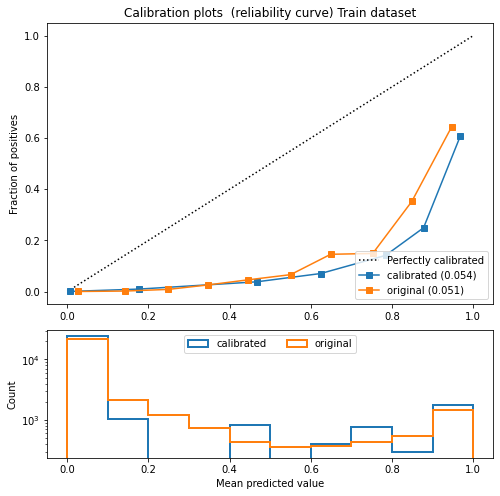

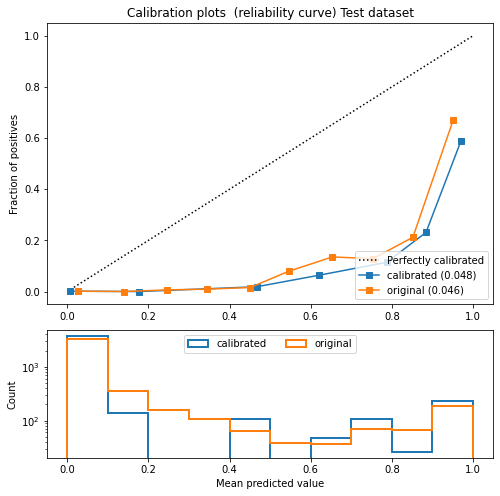

In [9]:
import matplotlib.pyplot as plt

fig_train = get_calibration_figure(model_calibrated, bst, x_train, y_train, 'Train')
display(fig_train)
#fig_val = get_calibration_figure(model_calibrated, bst, x_val, y_val, 'Validation')
fig_test = get_calibration_figure(model_calibrated, bst, x_test, y_test, 'Test')